# DeepLearning for TCGA Data

## Librerias

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import dask_ml.joblib
from matplotlib import pyplot

C:\Users\da.salazarb\AppData\Local\Continuum\anaconda3\envs\PythonR\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data

Los datos provienen de __[FireHose Brad GDAC](https://gdac.broadinstitute.org/)__ y del paquete de R __[TCGA-Assembler](https://github.com/compgenome365/TCGA-Assembler-2)__. 

En el archivo de R *Depuracion_TCGA-Assembler_Integrator.R* se realizo la consolidacion de los archivos. Se trabajo **cnv**, **meth** y **mrna**. Por tal motivo los archivos quedaron listo para usar, sin embargo, se requiere de preprocesameinto para **mrna**. Los genes de este dataSet tienen una varianza diversa, es decir, varianzas cercanas a cero y otras que superan el millon.

El siguiente documento vendra organizado por: <br>
1. [Funciones](#Funciones)
2. [PreprossData](#PreprossData)
3. [ANN](#ANN)

In [2]:
## Cual es la ruta actual?
os.getcwd()

'C:\\Users\\da.salazarb\\Google Drive\\Tutorial_2018-10\\03_Resultados\\DataTCGA'

******************************************************************************************************************************************

### Cargar archivos

Pasar a 
1. [Funciones](#Funciones)
2. [PreprossData](#PreprossData)
3. [ANN](#ANN)

******************************************************************************************************************************************

## Funciones 
[Retornar al inicio](#Data)

In [3]:
# Normalizar los datos
def escalarData(tcga, x_train, x_test):
    '''
    tcga: el perfil por ejemplo, mrna.
    x_train y x_test: las particiones de ese perfil (e.g. mrna)
    
    '''
    from sklearn.preprocessing import StandardScaler
    
    sc_x = StandardScaler()
    sc_x.fit(tcga)
    x_train_s = sc_x.transform(x_train)
    x_test_s = sc_x.transform(x_test)
    x_train_s=pd.DataFrame(x_train_s, index=x_train.index, columns=x_train.columns)
    x_test_s=pd.DataFrame(x_test_s, index=x_test.index, columns=x_test.columns)
    return x_train, x_test

# Train y dev set para una muestra de variables para cada perfil
# correr despues de cargar los archivos
def demoTrainDevSet(mrna, cnv, meth, dsurv, protein):
    #Lista de 100 variables aleatoria
    mrnaLista=['JPH1', 'MT1X', 'NR2E3', 'PEX5L', 'CHST6', 'VEGFC', 'TPSD1', 'TMUB1', 'ACER1', 'OXER1', 'VAV3', 'HAND2', 'CYP11A1', 'HS3ST3B1', 'HIF3A', 'RPL21', 'LDLR', 'MUC15', 'PON2', 'WDR72', 'SH2D4B', 'SLC7A2', 'S100A3', 'RCVRN', 'USP29', 'AQP2', 'FAM83H', 'SPAG4', 'TP53I11', 'SORCS3', 'GLT1D1', 'CCIN', 'TFAP2B', 'GAD1', 'EPHX3', 'KRT17', 'GUCY2D', 'DIRAS2', 'HIST1H2AB']
    mrna=mrna[mrnaLista]
    
    #Lista de 100 variables aleatoria
    cnvLista=['FAM8A1_CHR6_pos_cnv', 'LSP1P3_CHR5_pos_cnv', 'CDCP1_CHR3_neg_cnv', 'RPS14_CHR5_neg_cnv', 'THOC2_CHRX_neg_cnv', 'GPR6_CHR6_pos_cnv', 'LRRC10B_CHR11_pos_cnv', 'TSSK3_CHR1_pos_cnv', 'ATP6V1A_CHR3_pos_cnv', 'PLGLB2_CHR2_pos_cnv', 'SNORD68_CHR16_pos_cnv', 'TRIM66_CHR11_neg_cnv', 'UBE2N_CHR12_neg_cnv', 'TAOK1_CHR17_pos_cnv', 'ARHGAP10_CHR4_pos_cnv', 'CCDC9_CHR19_pos_cnv', 'IFNA13_CHR9_neg_cnv', 'DOK7_CHR4_pos_cnv', 'RBM44_CHR2_pos_cnv', 'SNRNP48_CHR6_pos_cnv', 'B3GNT3_CHR19_pos_cnv', 'ALOX5AP_CHR13_pos_cnv', 'ATRX_CHRX_neg_cnv', 'LOC643650_CHR10_neg_cnv', 'SREBF2_CHR22_pos_cnv', 'SNAI1_CHR20_pos_cnv', 'SHC3_CHR9_neg_cnv', 'CBX3P2_CHR18_neg_cnv', 'GOLGA6C_CHR15_pos_cnv', 'MAGEB1_CHRX_pos_cnv', 'ARHGAP42_CHR11_pos_cnv', 'KCNK9_CHR8_neg_cnv', 'SOS1_CHR2_neg_cnv', 'SERPINA10_CHR14_neg_cnv', 'CLEC18A_CHR16_pos_cnv', 'PDCD1LG2_CHR9_pos_cnv', 'ROR1_CHR1_pos_cnv', 'APOBEC1_CHR12_neg_cnv', 'PRKD1_CHR14_neg_cnv', 'RNF41_CHR12_neg_cnv', 'COX6A2_CHR16_neg_cnv', 'RTL8B_CHRX_neg_cnv', 'MINDY1_CHR1_neg_cnv', 'F2RL2_CHR5_neg_cnv', 'LOXL2_CHR8_neg_cnv', 'LOC100498859_CHR3_pos_cnv', 'GK2_CHR4_neg_cnv', 'SNORD1A_CHR17_pos_cnv', 'LGSN_CHR6_neg_cnv', 'POLI_CHR18_pos_cnv', 'CD24_CHRY_neg_cnv', 'KLHL11_CHR17_neg_cnv']
    cnv=cnv[cnvLista]
    
    #Lista de 100 variables aleatoria
    methLista=['IL6_Met', 'KCNF1_Met', 'OSTBETA_Met', 'ITGA8_Met', 'ALOX15_Met', 'CCNL1_Met', 'CCM2_Met', 'CXCL1_Met', 'KCNH8_Met', 'RASD2_Met', 'TMEM49_Met', 'HLA.A_Met']
    meth=meth[methLista]
    
    #Lista de 100 variables aleatoria
    proteinLista=['XRCC5_Protein', 'FASN_Protein', 'CDKN1A_Protein', 'SMAD1_Protein', 'TFRC_Protein', 'BCL2_Protein', 'GAPDH_Protein', 'SYK_Protein', 'CDKN1B_Protein', 'NFKB1_Protein', 'PDCD4_Protein', 'RPS6_Protein.2', 'ERBB2_Protein', 'PCNA_Protein', 'MAPK14_Protein.1', 'CDK1_Protein', 'LCK_Protein', 'MYH11_Protein', 'G6PD_Protein', 'ASNS_Protein', 'AXL_Protein', 'AKT1 AKT2 AKT3_Protein.1', 'BECN1_Protein', 'ITGA2_Protein', 'PRKAA1_Protein', 'BRD4_Protein', 'CAV1_Protein', 'IRF1_Protein', 'SETD2_Protein', 'EGFR_Protein.1', 'CDH3_Protein', 'MAP2K1_Protein', 'SRC_Protein', 'MYH9_Protein']
    protein=protein[proteinLista]
    
    # Varianza
    mrna=varianceSelection(mrna, THRESHOLD=0.5)
    cnv=varianceSelection(cnv, THRESHOLD=0.01)
    meth=varianceSelection(meth, THRESHOLD=0.001)
    protein=varianceSelection(protein, THRESHOLD=0.1)
    
    # Obtener train y dev set de cada profile
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(mrna, dsurv.iloc[:,1:], test_size=.2)
    cnv_train=cnv.loc[x_train.index,]
    cnv_test=cnv.loc[x_test.index,]
    meth_train=meth.loc[x_train.index,]
    meth_test=meth.loc[x_test.index,]
    protein_train=protein.loc[x_train.index,]
    protein_test=protein.loc[x_test.index,]

    # Normalizar datos
    x_train, x_test = escalarData(mrna, x_train, x_test)
    cnv_train, cnv_test = escalarData(cnv, cnv_train, cnv_test)
    meth_train, meth_test = escalarData(meth, meth_train, meth_test)
    protein_train, protein_test = escalarData(protein, protein_train, protein_test)
    
    print("Nuevas dimensiones mrna: {0}".format(mrna.shape))
    print("Nuevas dimensiones cnv: {0}".format(cnv.shape))
    print("Nuevas dimensiones meth: {0}".format(meth.shape))
    print("Nuevas dimensiones dsurv: {0}".format(dsurv.shape))
    print("Nuevas dimensiones protein: {0}".format(protein.shape))
    
    return mrna, cnv, meth, dsurv, protein, x_train, x_test, y_train, y_test, cnv_train, cnv_test, meth_train, meth_test, protein_train, protein_test

In [28]:
#Normalizar datos
def normalizar(tcga):
    from sklearn.preprocessing import StandardScaler
    sc_x = StandardScaler()
    sc_x.fit(tcga)
    x_train_s = sc_x.transform(tcga)
    x_train_s=pd.DataFrame(x_train_s, index=tcga.index, columns=tcga.columns)
    return x_train_s

# Seleccion de variables para varianzas pequeñas
def varianceSelection(X, THRESHOLD = 10):
    from sklearn.feature_selection import VarianceThreshold
    sel = VarianceThreshold(threshold=THRESHOLD)
    sel.fit_transform(X)
    return X[[c for (s, c) in zip(sel.get_support(), X.columns.values) if s]]

#Para cargar nuevamente los archivos de forma rapida
def reRunFiles(varX=False, logSurv=False, varianza=False, randVar=(False, 0), pcaVar=(False, 0)):
    '''
    varX: True para eliminar la primera variable que puede ser el identificador del paciente
    logSurv: True para sacar logaritmo de 'y' o dsurv
    varianza: True para eliminar variables por varianza segun threshold
    randVar: True para elegir variables, int para escoger una cantidad de variables
    
    
    '''
    mrna=pd.read_table("TCGA-Integrator/mrnaPrePros.txt")
    cnv=pd.read_table("TCGA-Integrator/cnvPrePros.txt")
    meth=pd.read_table("TCGA-Integrator/methPrePros.txt")
    dsurv=pd.read_table("TCGA-Integrator/dsurvPrePros.txt")
    protein=pd.read_table("TCGA-Integrator/new_gbm_Protein.txt", sep=",", index_col=0)
    # Los archivos vienen con una columna "X" que contiene los indices de los pacientes
    # si varX == True -> se elimina esa primera columna
    if varX == True:
        mrna=mrna.iloc[:,1:]
        cnv=cnv.iloc[:,1:]
        meth=meth.iloc[:,1:]
        dsurv=dsurv.iloc[:,1:]
    # Logaritmo a dsurv
    if logSurv == True:
        dsurv=np.log10(dsurv)
    # correccion de nombres para protein
    nombreProteinIndex=list(protein.index)
    nombreProteinIndex = [w.replace('-', '.') for w in nombreProteinIndex]
    protein.index=nombreProteinIndex
    protein=protein.loc[mrna.index,:]
    
    # Seleccionar por varianza
    if varianza == True:
        mrna=varianceSelection(mrna, THRESHOLD=0.5)
        cnv=varianceSelection(cnv, THRESHOLD=0.01)
        meth=varianceSelection(meth, THRESHOLD=0.001)
        protein=varianceSelection(protein, THRESHOLD=0.1)
    
    # Normalizar
    mrna = normalizar(mrna)
    cnv = normalizar(cnv)
    meth = normalizar(meth)
    protein = normalizar(protein)
    
    # variables aleatorias
    if randVar[0] == True:
        variables=np.random.choice(len(mrna.columns), randVar[1])
        mrna=mrna.iloc[:,variables]
        variables=np.random.choice(len(cnv.columns), randVar[1])
        cnv=cnv.iloc[:,variables]
        variables=np.random.choice(len(meth.columns), randVar[1])
        meth=meth.iloc[:,variables]
        variables=np.random.choice(len(protein.columns), randVar[1])
        protein=protein.iloc[:,variables]
    
    # PCA
    if pcaVar[0] == True:
        pca = PCA(n_components=pcaVar[1])
        mrna = pca.fit_transform(mrna)
        cnv = pca.fit_transform(cnv)
        meth = pca.fit_transform(meth)
        
    print("Dimensiones mrna: {0}".format(mrna.shape))
    print("Dimensiones cnv: {0}".format(cnv.shape))
    print("Dimensiones meth: {0}".format(meth.shape))
    print("Dimensiones dsurv: {0}".format(dsurv.shape))
    print("Dimensiones protein: {0}".format(protein.shape))
    return mrna, cnv, meth, dsurv, protein

In [29]:
#KFold para obtener los train y test de cada perfil
def kfoldProfiles(tcga, n_splits, seed): 
    from sklearn.model_selection import KFold
    kfold = KFold(n_splits=n_splits, random_state=seed, shuffle=True)
    splits = kfold.split(tcga)
    return splits

## PreprossData
[Retornar al inicio](#Data)

In [30]:
# Cargar datos
mrna, cnv, meth, dsurv, protein = reRunFiles(varX=True, logSurv=True, varianza=False, randVar=(False, 0), pcaVar=(True, 32))

Dimensiones mrna: (160, 11695)
Dimensiones cnv: (160, 23608)
Dimensiones meth: (160, 13774)
Dimensiones dsurv: (160, 1)
Dimensiones protein: (160, 138)


## Multicolinealidad

## Outliers (Opcional?)

In [38]:
from sklearn.ensemble import IsolationForest

In [107]:
clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(mrna.iloc[:,1:])
y_noano = clf.predict(mrna.iloc[:,1:])
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

ValueError: could not convert string to float: 'TCGA.76.4931.01'

In [44]:
train = mrna.iloc[y_noano[y_noano['Top'] == 1].index.values]

In [45]:
train.reset_index(drop = True, inplace = True)

In [47]:
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 16
Number of rows without outliers: 144


In [48]:
train.head()

,X,A1BG,A2ML1,A2M,A4GALT,A4GNT,AAAS,AACS,AADAC,AADAT,...,ZSCAN5A,ZSWIM1,ZSWIM3,ZSWIM7,ZW10,ZWILCH,ZWINT,ZYX,ZZEF1,ZZZ3
0,TCGA.02.0047.01,125.0069,41.1814,34012.4220,36.2642,1.2293,466.5171,481.8833,0.0000,233.5659,...,92.8117,248.3174,107.5632,311.3618,288.2695,260.2108,404.4378,3867.9738,1397.0927,603.5834
1,TCGA.02.0055.01,391.8038,1.6819,42876.2607,487.7365,0.5606,594.8143,317.3090,0.5606,99.7898,...,61.6678,266.8535,96.4261,313.5361,366.6433,467.5599,245.5501,11481.4296,606.0266,718.1500
2,TCGA.02.2483.01,271.8522,2.5330,21058.5203,86.9657,0.0000,1100.5805,493.0871,0.0000,259.2084,...,115.2507,258.3641,154.9340,455.5061,551.3456,682.2417,669.1293,5066.8074,832.0844,705.4354
3,TCGA.02.2485.01,83.9429,211.4286,7798.5333,155.2381,0.4762,1013.8095,304.2857,0.4762,190.0000,...,230.0000,267.1429,121.9048,330.5095,342.3810,440.3857,441.9048,5090.9524,1139.5238,700.4762
4,TCGA.02.2486.01,108.2561,103.6585,40971.4268,43.9024,0.0000,701.8293,392.0732,0.0000,217.0732,...,87.8049,251.8293,119.5122,972.3659,420.7317,166.6890,74.3902,7800.0000,627.4390,527.4390


******************************************************************************************************************************************

## ANN
[Retornar al inicio](#Data)

Este primer ejercicio de una red neuronal con varias capas ocultas y diferentes neuronas se tomo de __[Neural Network Model for House Prices (TensorFlow)](https://www.kaggle.com/zoupet/neural-network-model-for-house-prices-tensorflow)__.

1. Particion de datos usando sklearn.
2. Conversion de variables continuas en formato especial.
3. Definicion de la red

## Tensorflow

In [36]:
tf.logging.set_verbosity(tf.logging.ERROR) # No mostrar errores

In [ ]:
# Para las variables continuas se debe transformar los datos en un formato especial de tensorflow.

In [69]:
col_train = list(train.columns[1:]) #Quitar variable "X"
COLUMNS = col_train
LABEL = "Survival"

In [70]:
feature_cols = [tf.contrib.layers.real_valued_column(k) for k in COLUMNS]

In [71]:
training_set = pd.DataFrame(x_train, columns = COLUMNS).merge(y_train, left_index = True, right_index = True)

In [72]:
training_set.head()

,A1BG,A2ML1,A2M,A4GALT,A4GNT,AAAS,AACS,AADAC,AADAT,AAGAB,...,ZSWIM1,ZSWIM3,ZSWIM7,ZW10,ZWILCH,ZWINT,ZYX,ZZEF1,ZZZ3,Survival
TCGA.28.5207.01,188.8160,391.5215,25787.3147,174.4296,0.0000,866.7477,617.2539,0.0,115.0263,1046.0375,...,248.4137,147.4281,465.8836,360.7398,356.8192,218.1720,4417.4430,881.8685,938.0316,343
TCGA.26.5135.01,128.9241,10.1266,18844.2089,184.1772,4.4304,1061.3924,450.6329,0.0,205.6962,617.7215,...,321.5190,124.0506,346.8861,243.6709,271.4051,496.2025,13229.1139,1433.5443,565.1899,270
TCGA.26.1442.01,70.3618,307.2889,33418.2433,144.2056,3.6707,776.6125,292.0818,0.0,234.3996,731.5155,...,318.3010,118.5107,249.2606,261.6675,98.8201,91.2428,3595.1757,978.5003,471.9455,953
TCGA.76.4925.01,14.1449,10.2872,8703.3605,39.4342,1.2859,1076.2966,538.3626,0.0,285.8980,993.9991,...,373.3390,116.1595,254.9293,513.9306,482.8118,658.8084,10100.3000,752.6790,910.4158,146
TCGA.06.0152.02,30.7533,7.0023,34456.1043,76.5878,0.0000,856.0325,547.9308,0.0,233.7021,878.3524,...,387.3153,122.1028,353.9493,381.1883,449.0407,467.4042,12664.5543,1448.1654,629.3327,375


In [73]:
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = COLUMNS).merge(y_test, left_index = True, right_index = True)
testing_set.head()

,A1BG,A2ML1,A2M,A4GALT,A4GNT,AAAS,AACS,AADAC,AADAT,AAGAB,...,ZSWIM1,ZSWIM3,ZSWIM7,ZW10,ZWILCH,ZWINT,ZYX,ZZEF1,ZZZ3,Survival
TCGA.06.0238.01,228.3391,9.8039,18716.6609,159.7463,1.7301,1035.7555,621.1073,0.5767,261.8224,1253.1719,...,304.4983,186.2745,610.2076,276.8166,541.1822,517.8777,3979.2388,614.1869,682.2376,405
TCGA.06.0882.01,263.1515,234.6592,23898.0500,91.5171,2.3466,597.4422,312.0967,0.0000,192.8898,1154.5231,...,344.4796,156.2830,588.7317,333.6853,202.0744,109.3512,5589.1118,1070.0458,718.5263,632
TCGA.06.0158.01,225.4497,73.9844,32110.3600,94.6824,0.4404,812.0665,376.9680,0.0000,252.7799,831.8837,...,412.6390,152.3726,436.6267,324.1220,287.3236,240.4492,5548.3871,1256.8535,645.1613,329
TCGA.15.1444.01,125.9802,162.2352,24478.9229,72.5552,1.3520,659.7566,396.1244,0.0000,182.9653,808.4723,...,206.3993,124.8310,349.7116,446.1469,255.2681,276.2506,3470.4822,1672.8256,848.5804,1537
TCGA.14.0790.01,23.9113,245.7338,10514.6075,88.7372,1.3652,1047.7816,288.7372,0.0000,255.9727,875.0853,...,258.0205,85.3242,423.6451,290.1024,315.0990,325.5973,4351.5358,862.1160,617.0648,419


In [58]:
feature_cols[0:10]

[_RealValuedColumn(column_name='A1BG', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(column_name='A2ML1', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(column_name='A2M', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(column_name='A4GALT', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(column_name='A4GNT', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(column_name='AAAS', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(column_name='AACS', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(column_name='AADAC', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(column_name='AADAT', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(colu

In [60]:
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.relu, hidden_units=[200, 100, 50, 25, 12])

In [59]:
optimizer = tf.train.GradientDescentOptimizer( learning_rate= 0.1 )

In [74]:
training_set.reset_index(drop = True, inplace =True)

In [75]:
training_set.head() ## se va id del paciente

,A1BG,A2ML1,A2M,A4GALT,A4GNT,AAAS,AACS,AADAC,AADAT,AAGAB,...,ZSWIM1,ZSWIM3,ZSWIM7,ZW10,ZWILCH,ZWINT,ZYX,ZZEF1,ZZZ3,Survival
0,188.8160,391.5215,25787.3147,174.4296,0.0000,866.7477,617.2539,0.0,115.0263,1046.0375,...,248.4137,147.4281,465.8836,360.7398,356.8192,218.1720,4417.4430,881.8685,938.0316,343
1,128.9241,10.1266,18844.2089,184.1772,4.4304,1061.3924,450.6329,0.0,205.6962,617.7215,...,321.5190,124.0506,346.8861,243.6709,271.4051,496.2025,13229.1139,1433.5443,565.1899,270
2,70.3618,307.2889,33418.2433,144.2056,3.6707,776.6125,292.0818,0.0,234.3996,731.5155,...,318.3010,118.5107,249.2606,261.6675,98.8201,91.2428,3595.1757,978.5003,471.9455,953
3,14.1449,10.2872,8703.3605,39.4342,1.2859,1076.2966,538.3626,0.0,285.8980,993.9991,...,373.3390,116.1595,254.9293,513.9306,482.8118,658.8084,10100.3000,752.6790,910.4158,146
4,30.7533,7.0023,34456.1043,76.5878,0.0000,856.0325,547.9308,0.0,233.7021,878.3524,...,387.3153,122.1028,353.9493,381.1883,449.0407,467.4042,12664.5543,1448.1654,629.3327,375


In [78]:
def input_fn(data_set, pred = False):
    
    if pred == False:
        
        feature_cols = {k: tf.constant(data_set[k].values) for k in COLUMNS}
        labels = tf.constant(data_set[LABEL].values)
        
        return feature_cols, labels

    if pred == True:
        feature_cols = {k: tf.constant(data_set[k].values) for k in COLUMNS}
        
        return feature_cols

In [79]:
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x00000000193103C8>, 'hidden_units': [200, 100, 50, 25, 12], 'feature_columns': (_RealValuedColumn(column_name='A1BG', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='A2ML1', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='A2M', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='A4GALT', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='A4GNT', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='AAAS', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='AACS', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='AADAC', dimension=1, defau

In [81]:
type(regressor)

tensorflow.contrib.learn.python.learn.estimators.dnn.DNNRegressor

In [82]:
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)

In [83]:
loss_score1 = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score1))

Final Loss on the testing set: 3935110.000000


In [85]:
import itertools

In [86]:
y = regressor.predict(input_fn=lambda: input_fn(testing_set))
predictions = list(itertools.islice(y, testing_set.shape[0]))

In [91]:
predictions=pd.DataFrame(predictions)

,0
0,2650.169189
1,1381.403564
2,-1330.799561
3,96.981636
4,-1585.893311
5,-1552.393311
6,-860.408997
7,70.200386
8,-5647.081055
9,2620.934814


## Shallow neural network

In [101]:
def input_fn_new(data_set, training = True):
    continuous_cols = {k: tf.constant(data_set[k].values) for k in COLUMNS}
    
    #categorical_cols = {k: tf.SparseTensor(
        #indices=[[i, 0] for i in range(data_set[k].size)], values = data_set[k].values, dense_shape = [data_set[k].size, 1]) for k in FEATURES_CAT}

    # Merges the two dictionaries into one.
    feature_cols = dict(list(continuous_cols.items()))
    
    if training == True:
        # Converts the label column into a constant Tensor.
        label = tf.constant(data_set[LABEL].values)

        # Returns the feature columns and the label.
        return feature_cols, label
    
    return feature_cols

In [139]:
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.relu, hidden_units=[100,100,100,100,100])

In [140]:
regressor.fit(input_fn = lambda: input_fn_new(training_set) , steps=2000)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x00000000DD153550>, 'hidden_units': [100, 100, 100, 100, 100], 'feature_columns': (_RealValuedColumn(column_name='A1BG', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='A2ML1', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='A2M', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='A4GALT', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='A4GNT', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='AAAS', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='AACS', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='AADAC', dimension=1, de

In [141]:
ev = regressor.evaluate(input_fn=lambda: input_fn_new(testing_set, training = True), steps=1)
loss_score5 = ev["loss"]

In [142]:
print("Final Loss on the testing set: {0:f}".format(loss_score5))

Final Loss on the testing set: 298255.593750


## Keras

Para usar GridSearch con Keras ver este tutorial: __[Need help with Deep Learning? Take the FREE Mini-Course
How to Grid Search Hyperparameters for Deep Learning Models in Python With Keras](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/)__. Se buscan diferentes parametros. Sin embargo, se requiere mas poder computacional y reguralizacion.

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Input, Activation
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [383]:
# Definiendo el modelo
#ef modelKeras(input_shape, neurons):
def modelKeras(neurons=20):
    #x_input = Input(input_shape)
    x = Sequential()
    x.add(Dense(units=neurons, activation='relu'))#(x_input)
    x.add(Dense(units=neurons, activation='relu'))#(x)
    x.add(Dense(units=neurons, activation='relu'))#(x)
    x.add(Dense(units=1, activation='relu'))#(x)
    x.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])
    return x

In [384]:
model = KerasRegressor(build_fn=modelKeras)

In [390]:
history = model.fit(x_train.values, y_train.values, epochs=50, verbose=0)

In [391]:
model.score(x_test, y_test)

32/32 [==============================] - 0s 5ms/step


-148675.484375

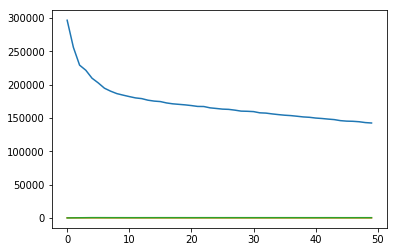

In [387]:
# plot metrics
pyplot.plot(history.history['mean_squared_error'])
pyplot.plot(history.history['mean_absolute_error'])
pyplot.plot(history.history['mean_absolute_percentage_error'])
pyplot.show()

## The Merge layers

Regresar a: 
1. [Funciones](#Funciones)
2. [PreprossData](#PreprossData)

### (mrna + cnv + meth)

In [27]:
mrna, cnv, meth, dsurv, protein = reRunFiles(varX=True, logSurv=True)
mrna, cnv, meth, dsurv, protein, x_train, x_test, y_train, y_test, cnv_train, cnv_test, meth_train, meth_test, protein_train, protein_test = demoTrainDevSet(mrna, cnv, meth, dsurv, protein)

Dimensiones mrna: (160, 11695)
Dimensiones cnv: (160, 23608)
Dimensiones meth: (160, 13774)
Dimensiones dsurv: (160, 1)
Dimensiones protein: (160, 138)
Nuevas dimensiones mrna: (160, 39)
Nuevas dimensiones cnv: (160, 48)
Nuevas dimensiones meth: (160, 10)
Nuevas dimensiones dsurv: (160, 1)
Nuevas dimensiones protein: (160, 16)


In [12]:
import keras
from keras.layers import Input, Embedding, Dense
from keras.models import Model

Using TensorFlow backend.


In [13]:
def modelKeras(input_shape, neurons):
    main_input = Input(shape=(input_shape)) #inputshape=x_train.shape[1:]
    nn = Dense(neurons, activation="relu")(main_input)
    nn = Dense(neurons, activation="relu")(nn)
    nn = Dense(neurons, activation="relu")(nn)
    nn = Dense(neurons, activation="relu")(nn)
    nn = Dense(neurons, activation="relu")(nn)
    return nn, main_input

In [14]:
def multiModelKeras(x_train, cnv_train, meth_train):
    mrna_nn, mrna_input = modelKeras(x_train.shape[1:], 100)
    cnv_nn, cnv_input = modelKeras(cnv_train.shape[1:], 10)
    meth_nn, meth_input = modelKeras(meth_train.shape[1:], 10)
    #protein_nn, protein_input = modelKeras(protein_train.shape[1:], 100)
    mrna_cnv_meth = keras.layers.concatenate([mrna_nn, cnv_nn, meth_nn])
    x = Dense(100, activation='relu')(mrna_cnv_meth)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    main_output = Dense(1, activation='relu', name='main_output')(x)
    model = Model(inputs=[mrna_input, cnv_input, meth_input], outputs=main_output)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])
    return model

In [15]:
from sklearn.model_selection import LeaveOneOut

In [16]:
# define 10-fold cross validation test harness
loco = LeaveOneOut()
cvscores = []

In [17]:
def modelKeras(input_shape, neurons):
    main_input = Input(shape=(input_shape)) #inputshape=x_train.shape[1:]
    nn = Dense(neurons, activation="relu")(main_input)
    nn = Dense(neurons, activation="relu")(nn)
    nn = Dense(neurons, activation="relu")(nn)
    nn = Dense(neurons, activation="relu")(nn)
    return nn, main_input

def allToDNN(mrna, cnv, meth, prot, neurons):
    mrnaDNN = modelKeras(mrna.shape[1:], neurons)
    cnvDNN = modelKeras(cnv.shape)

1/1 [==============================] - 0s 78ms/step
MSE: 7.03 Iteracion: 1 
1/1 [==============================] - 0s 117ms/step
MSE: 3.54 Iteracion: 2 
1/1 [==============================] - 0s 163ms/step
MSE: 7.12 Iteracion: 3 
1/1 [==============================] - 0s 238ms/step
MSE: 7.14 Iteracion: 4 
1/1 [==============================] - 0s 258ms/step
MSE: 7.79 Iteracion: 5 
1/1 [==============================] - 0s 291ms/step
MSE: 9.99 Iteracion: 6 
1/1 [==============================] - 0s 351ms/step
MSE: 9.99 Iteracion: 7 
1/1 [==============================] - 0s 466ms/step
MSE: 9.06 Iteracion: 8 
1/1 [==============================] - 0s 451ms/step
MSE: 6.74 Iteracion: 9 
1/1 [==============================] - 1s 518ms/step
MSE: 8.34 Iteracion: 10 
1/1 [==============================] - 1s 563ms/step
MSE: 8.22 Iteracion: 11 
1/1 [==============================] - 1s 617ms/step
MSE: 6.23 Iteracion: 12 
1/1 [==============================] - 1s 742ms/step
MSE: 6.63 Iteracion: 

In [25]:
print(np.mean(cvscores))
print(np.var(cvscores))

6.15448720883578
4.232612277203989


In [367]:
model.fit([x_train, cnv_train, meth_train], y_train,
          epochs=25, batch_size=32)

Epoch 1/25
128/128 [==============================] - 0s 86us/step - loss: 37398.1167 - mean_squared_error: 37398.1167 - mean_absolute_error: 131.2671 - mean_absolute_percentage_error: 137.4021
Epoch 2/25
128/128 [==============================] - 0s 78us/step - loss: 28938.1636 - mean_squared_error: 28938.1636 - mean_absolute_error: 123.2770 - mean_absolute_percentage_error: 181.5998
Epoch 3/25
128/128 [==============================] - 0s 86us/step - loss: 25312.5847 - mean_squared_error: 25312.5847 - mean_absolute_error: 104.1454 - mean_absolute_percentage_error: 104.1512
Epoch 4/25
128/128 [==============================] - 0s 70us/step - loss: 24591.4211 - mean_squared_error: 24591.4211 - mean_absolute_error: 100.2580 - mean_absolute_percentage_error: 127.5200
Epoch 5/25
128/128 [==============================] - 0s 70us/step - loss: 24757.1030 - mean_squared_error: 24757.1030 - mean_absolute_error: 106.6938 - mean_absolute_percentage_error: 152.1975
Epoch 6/25
128/128 [==========

In [366]:
# 50 ephocs
model.evaluate([x_test, cnv_test, meth_test], y_test, batch_size=128)

[137829.875, 137829.875, 276.17135620117188, 107.73342895507813]

In [368]:
# early stop -> 25 stops
model.evaluate([x_test, cnv_test, meth_test], y_test, batch_size=128)

32/32 [==============================] - 0s 31us/step


[134395.875, 134395.875, 272.712646484375, 94.413642883300781]

### Protein + (mrna + cnv + meth)

In [18]:
import keras
from keras.layers import Input, Dropout, Dense
from sklearn.model_selection import LeaveOneOut
from keras.models import Model

In [451]:
def modelKeras(input_shape, neurons):
    main_input = Input(shape=(input_shape)) #inputshape=x_train.shape[1:]
    nn = Dense(neurons, activation="relu")(main_input)
    nn = Dense(neurons, activation="relu")(nn)
    nn = Dense(neurons, activation="relu")(nn)
    nn = Dense(neurons, activation="relu")(nn)
    nn = Dense(neurons, activation="relu")(nn)
    return nn, main_input

In [458]:
def multiModelKerasComplet(x_train, cnv_train, meth_train, protein_input):
    mrna_nn, mrna_input = modelKeras(x_train.shape[1:], 100)
    cnv_nn, cnv_input = modelKeras(cnv_train.shape[1:], 10)
    meth_nn, meth_input = modelKeras(meth_train.shape[1:], 10)
    protein_nn, protein_input = modelKeras(protein_train.shape[1:], 100)
    mrna_cnv_meth = keras.layers.concatenate([mrna_nn, cnv_nn, meth_nn])
    x = Dense(100, activation='relu')(mrna_cnv_meth)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    all_profiles = keras.layers.concatenate([x,protein_nn])
    x = Dense(100, activation='relu')(all_profiles)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    main_output = Dense(1, activation='relu', name='main_output')(x)
    model = Model(inputs=[mrna_input, cnv_input, meth_input, protein_input], outputs=main_output)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])
    return model

In [460]:
# define 10-fold cross validation test harness
loco = LeaveOneOut()
cvscores = []

In [461]:
for train, test in loco.split(mrna):
    # Crear el modelo
    model = multiModelKerasComplet(mrna, cnv, meth, protein)
    # Fit the model
    model.fit([mrna.iloc[train,:], cnv.iloc[train,:], meth.iloc[train,:], protein.iloc[train,:]], dsurv.iloc[:,1:].iloc[train,:], epochs=150, batch_size=10, verbose=0)
    # Evaluar el modelo
    scores = model.evaluate([mrna.iloc[test,:], cnv.iloc[test,:], meth.iloc[test,:], protein.iloc[test,:]], dsurv.iloc[:,1:].iloc[test,:])
    print("MSE: %.2f%" % (scores[0]))
    cvscores.append(scores[0])

1/1 [==============================] - 15s 15s/step
MSE: 70.47%
1/1 [==============================] - 16s 16s/step
MSE: 676752.38%
1/1 [==============================] - 15s 15s/step
MSE: 6299.31%
1/1 [==============================] - 16s 16s/step
MSE: 12181.06%
1/1 [==============================] - 17s 17s/step
MSE: 72130.54%
1/1 [==============================] - 17s 17s/step
MSE: 1148566.12%
1/1 [==============================] - 19s 19s/step
MSE: 474314.34%
1/1 [==============================] - 18s 18s/step
MSE: 308278.97%
1/1 [==============================] - 17s 17s/step
MSE: 167343.31%
1/1 [==============================] - 18s 18s/step
MSE: 594441.00%
1/1 [==============================] - 18s 18s/step
MSE: 543169.00%
1/1 [==============================] - 21s 21s/step
MSE: 8012.37%
1/1 [==============================] - 21s 21s/step
MSE: 48500.55%
1/1 [==============================] - 22s 22s/step
MSE: 165111.92%
1/1 [==============================] - 26s 26s/step
MSE: 4

KeyboardInterrupt: 

In [377]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])

In [381]:
model.fit([x_train, cnv_train, meth_train, protein_train], y_train,
          epochs=50, batch_size=32)

Epoch 1/50
128/128 [==============================] - 0s 148us/step - loss: 329726.5234 - mean_squared_error: 329726.5234 - mean_absolute_error: 419.2734 - mean_absolute_percentage_error: 100.0000
Epoch 2/50
128/128 [==============================] - 0s 141us/step - loss: 329726.5312 - mean_squared_error: 329726.5312 - mean_absolute_error: 419.2734 - mean_absolute_percentage_error: 100.0000
Epoch 3/50
128/128 [==============================] - 0s 94us/step - loss: 329726.5234 - mean_squared_error: 329726.5234 - mean_absolute_error: 419.2734 - mean_absolute_percentage_error: 100.0000
Epoch 4/50
128/128 [==============================] - 0s 86us/step - loss: 329726.5234 - mean_squared_error: 329726.5234 - mean_absolute_error: 419.2734 - mean_absolute_percentage_error: 100.0000
Epoch 5/50
128/128 [==============================] - 0s 94us/step - loss: 329726.5234 - mean_squared_error: 329726.5234 - mean_absolute_error: 419.2734 - mean_absolute_percentage_error: 100.0000
Epoch 6/50
128/128

In [382]:
# 50 ephocs
model.evaluate([x_test, cnv_test, meth_test, protein_test], y_test, batch_size=128)

32/32 [==============================] - 0s 62us/step


[279155.71875, 279155.71875, 413.15625, 100.0]

In [380]:
# 25 ephocs
model.evaluate([x_test, cnv_test, meth_test, protein_test], y_test, batch_size=128)

32/32 [==============================] - 0s 4ms/step


[279155.71875, 279155.71875, 413.15625, 100.0]

In [59]:
d=[1,2,3,34,4,4,5,566,53,2,2]
d.append(12)
np.mean(d)

57.333333333333336

## mrna + cnv + meth + prot

In [10]:
import keras
from keras.layers import Input, Dropout, Dense
from sklearn.model_selection import LeaveOneOut
from keras.models import Model

Using TensorFlow backend.


In [11]:
mrna, cnv, meth, dsurv, protein = reRunFiles(varX=True, logSurv=True)
mrna, cnv, meth, dsurv, protein, x_train, x_test, y_train, y_test, cnv_train, cnv_test, meth_train, meth_test, protein_train, protein_test = demoTrainDevSet(mrna, cnv, meth, dsurv, protein)

Dimensiones mrna: (160, 11695)
Dimensiones cnv: (160, 23608)
Dimensiones meth: (160, 13774)
Dimensiones dsurv: (160, 1)
Dimensiones protein: (160, 138)
Nuevas dimensiones mrna: (160, 39)
Nuevas dimensiones cnv: (160, 48)
Nuevas dimensiones meth: (160, 10)
Nuevas dimensiones dsurv: (160, 1)
Nuevas dimensiones protein: (160, 16)


In [12]:
def modelKeras(input_shape, neurons, dropOut, activation):
    main_input = Input(shape=(input_shape)) #inputshape=x_train.shape[1:]
    nn = Dense(neurons, activation=activation)(main_input)
    nn = Dropout(dropOut)(nn)
    nn = Dense(neurons, activation=activation)(nn)
    nn = Dropout(dropOut)(nn)
    nn = Dense(neurons, activation=activation)(nn)
    nn = Dropout(dropOut)(nn)
    nn = Dense(neurons, activation=activation)(nn)
    nn = Dropout(dropOut)(nn)
    nn = Dense(neurons, activation=activation)(nn)
    nn = Dropout(dropOut)(nn)
    nn = Dense(neurons, activation=activation)(nn)
    nn = Dropout(dropOut)(nn)
    nn = Dense(neurons, activation=activation)(nn)
    nn = Dropout(dropOut)(nn)
    nn = Dense(neurons, activation=activation)(nn)
    nn = Dropout(dropOut)(nn)
    nn = Dense(neurons, activation=activation)(nn)
    nn = Dropout(dropOut)(nn)
    nn = Dense(neurons, activation=activation)(nn)
    nn = Dropout(dropOut)(nn)
    nn = Dense(neurons, activation=activation)(nn)
    nn = Dropout(dropOut)(nn)
    nn = Dense(neurons, activation=activation)(nn)
    nn = Dropout(dropOut)(nn)
    return nn, main_input

def allToDNN(mrna, cnv, meth, prot, neurons, dropOut, activation):
    mrnaDNN, mrnaInput = modelKeras(mrna.shape[1:], neurons, dropOut, activation)
    cnvDNN, cnvInput = modelKeras(cnv.shape[1:], neurons, dropOut, activation)
    methDNN, methInput = modelKeras(meth.shape[1:], neurons, dropOut, activation)
    proteinDNN, proteinInput = modelKeras(protein.shape[1:], neurons, dropOut, activation)
    
    all_profiles = keras.layers.concatenate([mrnaDNN, cnvDNN, methDNN, proteinDNN])
    
    x = Dense(neurons, activation=activation)(all_profiles)
    x = Dropout(dropOut)(x)
    x = Dense(neurons, activation=activation)(x)
    x = Dropout(dropOut)(x)
    x = Dense(neurons, activation=activation)(x)
    x = Dropout(dropOut)(x)
    x = Dense(neurons, activation=activation)(x)
    x = Dropout(dropOut)(x)
    x = Dense(neurons, activation=activation)(x)
    x = Dropout(dropOut)(x)
    x = Dense(neurons, activation=activation)(x)
    x = Dropout(dropOut)(x)
    x = Dense(neurons, activation=activation)(x)
    x = Dropout(dropOut)(x)
    x = Dense(neurons, activation=activation)(x)
    x = Dropout(dropOut)(x)
    x = Dense(neurons, activation=activation)(x)
    x = Dropout(dropOut)(x)
    x = Dense(neurons, activation=activation)(x)
    x = Dropout(dropOut)(x)
    x = Dense(neurons, activation=activation)(x)
    x = Dropout(dropOut)(x)
    x = Dense(neurons, activation=activation)(x)
    x = Dropout(dropOut)(x)
    main_output = Dense(1, activation=activation, name='main_output')(x)
    
    model = Model(inputs=[mrnaInput, cnvInput, methInput, proteinInput], outputs=main_output)
    #model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

In [22]:
#model = allToDNN(mrna, cnv, meth, protein, neurons=100, dropOut=.5, activation="relu")
#model.fit([mrna, cnv, meth, protein], dsurv, epochs=100, verbose=1, validation_split=0.2)

Train on 128 samples, validate on 32 samples
Epoch 1/100
128/128 [==============================] - 8s 61ms/step - loss: 1096575.9375 - mean_squared_error: 1096575.9375 - val_loss: 5.7162 - val_mean_squared_error: 5.7162
Epoch 2/100
128/128 [==============================] - 0s 617us/step - loss: 125130.7521 - mean_squared_error: 125130.7521 - val_loss: 5.7162 - val_mean_squared_error: 5.7162
Epoch 3/100
128/128 [==============================] - 0s 609us/step - loss: 2049.7347 - mean_squared_error: 2049.7347 - val_loss: 5.7162 - val_mean_squared_error: 5.7162
Epoch 4/100
128/128 [==============================] - 0s 625us/step - loss: 1169.6099 - mean_squared_error: 1169.6099 - val_loss: 5.7162 - val_mean_squared_error: 5.7162
Epoch 5/100
128/128 [==============================] - 0s 586us/step - loss: 59.4431 - mean_squared_error: 59.4431 - val_loss: 5.7162 - val_mean_squared_error: 5.7162
Epoch 6/100
128/128 [==============================] - 0s 594us/step - loss: 104.5673 - mean_sq

## Evaluacion de parametros

In [17]:
# Parametros a evaluar
parametros = {
    "neurons":[10,100, 500, 1000, 5000],
    "dropOut":[0,.2,.4,.6,.8], 
    "activation":["selu", "relu" ,"tanh", "sigmoid", "hard_sigmoid"]
}

In [ ]:
keysParams=list(parametros.keys())
consolidado = {}
for neuron in parametros[keysParams[0]]:
    for drop in parametros[keysParams[1]]:
        for activ in parametros[keysParams[2]]:
            saveEval=[]
            for ix_train, ix_test in kfoldProfiles(mrna, n_splits=3, seed=10):
                mrna_train=mrna.iloc[ix_train,]
                mrna_test=mrna.iloc[ix_test,]
                cnv_train=cnv.iloc[ix_train,]
                cnv_test=cnv.iloc[ix_test,]
                meth_train=meth.iloc[ix_train,]
                meth_test=meth.iloc[ix_test,]
                protein_train=protein.iloc[ix_train,]
                protein_test=protein.iloc[ix_test,]
                dsurv_train=dsurv.iloc[ix_train,]
                dsurv_test=dsurv.iloc[ix_test,]

                model = allToDNN(mrna_train, cnv_train, meth_train, protein_train, neurons=neuron, dropOut=drop, activation=activ)
                model.fit([mrna_train, cnv_train, meth_train, protein_train], dsurv_train, epochs=100, verbose=0)
                saveEval.append(model.evaluate([mrna_test, cnv_test, meth_test, protein_test], dsurv_test, batch_size=20)[1])
            consolidado["neuron: " + str(neuron) + " - " + "dropOut: " + str(drop) + " - " + "activation: " + str(activ)] = [np.mean(saveEval), np.var(saveEval)]

53/53 [==============================] - 456s 9s/step


In [ ]:
parametros = {
    "activation": ["softmax", "elu", "selu", "softplus", "softsign", "relu" ,"tanh", "sigmoid", "hard_sigmoid", "linear"],
    "optimizer": ["SGD", "RMSprop", "Adagrad", "Adadelta", "Adam", "Adamax", "Nadam"], 
    "drop": [0.2,0.4,0.6,0.8,1],
    "kernel": ["random_normal", "he_uniform", "lecun_normal", "he_normal", "glorot_uniform", "glorot_normal", "lecun_uniform", "zeros", "ones"], 
    "neurons": [5,10,50,100]
    #"moreHiddenLayers": [True, False]
}

In [16]:
consolidado

{'neuron: 10 dropOut: 0 activation: hard_sigmoid': [2.2893303602933885,
  0.07045023477055755],
 'neuron: 10 dropOut: 0 activation: relu': [1.6679292343556882,
  6.45233401136309],
 'neuron: 10 dropOut: 0 activation: selu': [0.3523627985268831,
  0.014645620210377802],
 'neuron: 10 dropOut: 0 activation: sigmoid': [2.4670102894306183,
  0.10756802981772502],
 'neuron: 10 dropOut: 0 activation: tanh': [2.297404333949089,
  0.07010535185744544],
 'neuron: 10 dropOut: 0.2 activation: hard_sigmoid': [2.2893303602933885,
  0.07045023477055755],
 'neuron: 10 dropOut: 0.2 activation: relu': [0.32286396585404875,
  0.0030789831382900096],
 'neuron: 10 dropOut: 0.2 activation: selu': [0.2735787585377693,
  0.01177260077224105],
 'neuron: 10 dropOut: 0.2 activation: sigmoid': [2.448762908577919,
  0.14871793601046496],
 'neuron: 10 dropOut: 0.2 activation: tanh': [2.2908347874879835,
  0.07061441219766967],
 'neuron: 10 dropOut: 0.4 activation: hard_sigmoid': [2.2893303602933885,
  0.07045023477

******************************************************************************************************************************************

### Usando un cluster - "Dask"

No para keras?

In [269]:
from dask.distributed import Client
client = Client(processes=False)
client

Client Scheduler: inproc://157.253.199.132/10012/19 Dashboard: http://localhost:62121/status,Cluster Workers: 1 Cores: 8 Memory: 17.08 GB


In [270]:
import dask_ml.joblib
from sklearn.externals import joblib